In [1]:
from math import factorial, pi
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from scipy.special import gamma
from tqdm import tqdm

from polypart.arrangements import get_random_arrangement
from polypart.polytopes import sample_poisson_zero_cell_polytope
from polypart.ppart import build_partition_tree

## Examples of random zero-cell sampling


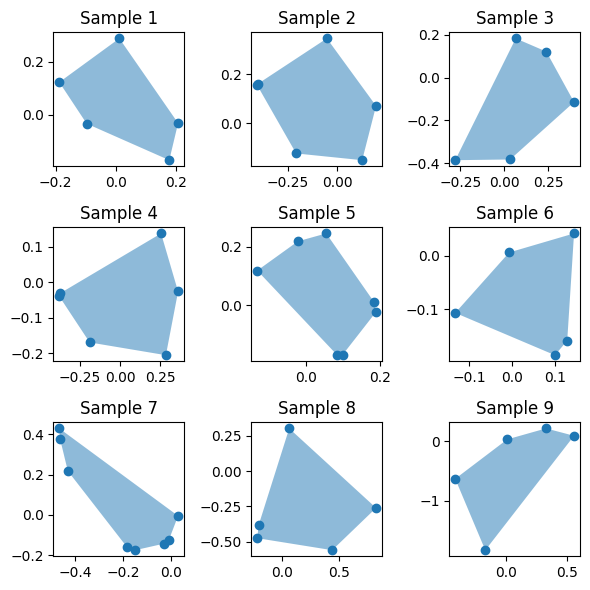

In [2]:
N_POLYTOPES = 9

# Put them in a 2d subplot grid for better visualization
fig, axs = plt.subplots(int(N_POLYTOPES**0.5), int(N_POLYTOPES**0.5), figsize=(6, 6))
for i in range(N_POLYTOPES):
    P = sample_poisson_zero_cell_polytope(
        d=2, intensity=10, window_radius=1, decimals=4, seed=None
    )
    P.remove_redundancies()
    hull = ConvexHull(P.vertices)
    ax = axs[i // int(N_POLYTOPES**0.5), i % int(N_POLYTOPES**0.5)]
    ax.fill(P.vertices[hull.vertices, 0], P.vertices[hull.vertices, 1], alpha=0.5)
    ax.plot(P.vertices[:, 0], P.vertices[:, 1], "o")
    ax.set_title(f"Sample {i + 1}")
plt.tight_layout()
plt.show()

## Examples of arrangements inside a polytope


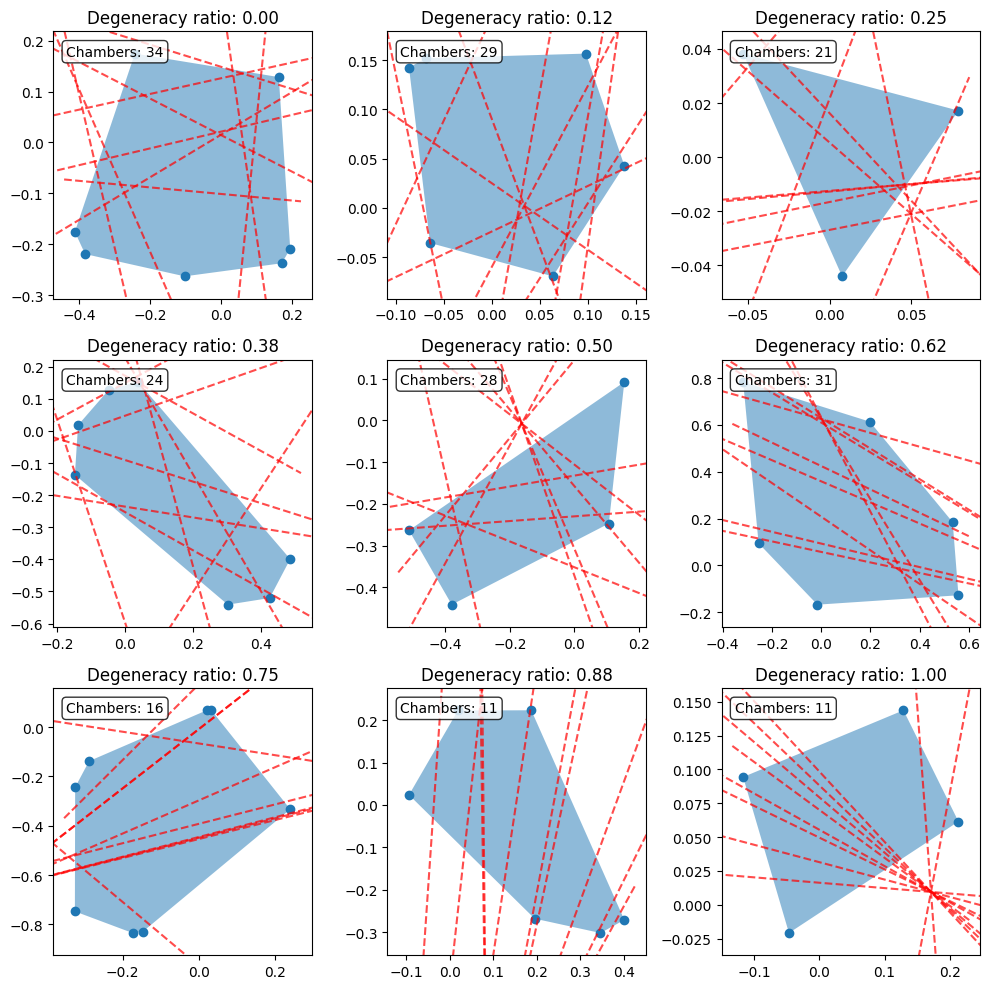

In [3]:
N_POLYTOPES = 9

# Put them in a 2d subplot grid for better visualization
fig, axs = plt.subplots(int(N_POLYTOPES**0.5), int(N_POLYTOPES**0.5), figsize=(10, 10))
degen_ratios = np.linspace(0.0, 1.0, N_POLYTOPES)
for i in range(N_POLYTOPES):
    P = sample_poisson_zero_cell_polytope(
        d=2, intensity=10, window_radius=1, decimals=4, seed=None
    )
    P.remove_redundancies()
    hull = ConvexHull(P.vertices)
    ax = axs[i // int(N_POLYTOPES**0.5), i % int(N_POLYTOPES**0.5)]
    ax.fill(P.vertices[hull.vertices, 0], P.vertices[hull.vertices, 1], alpha=0.5)
    ax.plot(P.vertices[:, 0], P.vertices[:, 1], "o")

    # Now sample an arrangement of hyperplanes and plot it on top
    m = 10
    arrangement = get_random_arrangement(P, m, degen_ratio=degen_ratios[i], seed=None)

    _, n_chambers = build_partition_tree(P, arrangement)

    ax.set_title(f"Degeneracy ratio: {degen_ratios[i]:.2f}")
    for h in arrangement:
        # Plot the hyperplane within the window
        x_vals = np.array(ax.get_xlim())
        a, b = h.normal
        c = h.offset
        # Ecuation is a*x + b*y = c  => y = (c - a*x)/b
        if b != 0:
            y_vals = (c - a * x_vals) / b
            ax.plot(x_vals, y_vals, "r--", alpha=0.7)
        else:
            # Vertical line
            x = c / a
            y_vals = np.array(ax.get_ylim())
            ax.plot([x, x], y_vals, "r--", alpha=0.7)

    # BBox around polytope vertices
    min_x, max_x = float(np.min(P.vertices[:, 0])), float(np.max(P.vertices[:, 0]))
    min_y, max_y = float(np.min(P.vertices[:, 1])), float(np.max(P.vertices[:, 1]))
    ax.set_xlim(min_x - 0.1 * (max_x - min_x), max_x + 0.1 * (max_x - min_x))
    ax.set_ylim(min_y - 0.1 * (max_y - min_y), max_y + 0.1 * (max_y - min_y))

    # Add number of chambers
    ax.text(
        0.05,
        0.95,
        f"Chambers: {n_chambers}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )


plt.tight_layout()
plt.show()

## How well does finite poisson process approximate real poisson zero-cell?


In [4]:
INTENSITY = 50
N_SAMPLES = 200
D = 5

# sample 100 polytopes and compute average time, number of vertices, and number of inequalities
total_time = 0.0
f0_counts = []
fdm1_counts = []
for i in tqdm(range(N_SAMPLES)):
    start_time = perf_counter()
    P = sample_poisson_zero_cell_polytope(
        d=D, intensity=INTENSITY, window_radius=1, decimals=3, seed=None
    )
    # P = sample_zero_cell_polytope(d=4, m=40, decimals=3, seed=None)
    P.remove_redundancies()
    end_time = perf_counter()
    elapsed_time = end_time - start_time
    total_time += elapsed_time
    f0_counts.append(P.n_vertices)
    fdm1_counts.append(P.n_inequalities)

avg_time = total_time / N_SAMPLES
avg_vertices = np.mean(f0_counts)
avg_inequalities = np.mean(fdm1_counts)
variance_vertices = np.var(f0_counts)
variance_inequalities = np.var(fdm1_counts)

print(f"Average time per sample: {avg_time:.4f} seconds.")
print(f"Expected number of vertices: {avg_vertices:.2f}+-{variance_vertices**0.5:.2f}.")
print(
    f"Expected number of facets: {avg_inequalities:.2f}+-{variance_inequalities**0.5:.2f}."
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:05<00:00,  3.04it/s]

Average time per sample: 0.3275 seconds.
Expected number of vertices: 99.43+-38.65.
Expected number of facets: 17.27+-3.31.


In [6]:
def k_d(d):
    """Volume of the unit ball in d dimensions."""
    return (np.pi ** (d / 2)) / gamma((d / 2) + 1)


def schneider_expected_vertices(d):
    return (2**-d) * factorial(d) * k_d(d) ** 2


def schneider_variance_vertices_typical_cell(d):
    varf0 = 2**d * factorial(d)
    vol_term = sum((k_d(j) ** 2) / (4**j * factorial(d - j)) for j in range(d + 1))
    return varf0 * vol_term - 2 ** (2 * d)


def kablucho_expected_facets(d):
    return (2 * pi / 3) ** (0.5) * (d ** (1.5))


print(
    f"Schneider expected number of vertices in Poisson zero cell (d={D}): {schneider_expected_vertices(D):.2f}"
)
print(
    f"Schneider std of number of vertices in Poisson typical cell (d={D}): {schneider_variance_vertices_typical_cell(D) ** 0.5:.2f}"
)
print(
    f"Kablucho asympotic number of facets in Poisson zero cell (d={D}): {kablucho_expected_facets(D):.2f}"
)

Schneider expected number of vertices in Poisson zero cell (d=5): 103.90
Schneider std of number of vertices in Poisson typical cell (d=5): 23.63
Kablucho asympotic number of facets in Poisson zero cell (d=5): 16.18
